In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from mapping import map_str_values
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime as dt

## Data

In [2]:
X = pd.read_csv("data/train_values.csv", index_col="building_id")
Y = pd.read_csv("data/train_labels.csv", index_col="building_id") - 1
# X = map_str_values(X)

## Áp dụng one hot encode cho các biến phân loại 

In [3]:
encoded_temp = pd.get_dummies(X["count_floors_pre_eq"], prefix="count_floors").astype(int)
encoded_temp


,count_floors_1,count_floors_2,count_floors_3,count_floors_4,count_floors_5,count_floors_6,count_floors_7,count_floors_8,count_floors_9
building_id,,,,,,,,,
802906,0,1,0,0,0,0,0,0,0
28830,0,1,0,0,0,0,0,0,0
94947,0,1,0,0,0,0,0,0,0
590882,0,1,0,0,0,0,0,0,0
201944,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
688636,1,0,0,0,0,0,0,0,0
669485,0,1,0,0,0,0,0,0,0
602512,0,0,1,0,0,0,0,0,0


In [4]:
X_encoded = pd.get_dummies(X, dtype=int).drop(columns="count_floors_pre_eq")
# X_encoded.assign(encoded_temp)
# X_encoded.dtypes
for temp_col in encoded_temp.columns:
    X_encoded[temp_col] = encoded_temp[temp_col]

In [5]:
X_encoded

,geo_level_1_id,geo_level_2_id,geo_level_3_id,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,legal_ownership_status_w,count_floors_1,count_floors_2,count_floors_3,count_floors_4,count_floors_5,count_floors_6,count_floors_7,count_floors_8,count_floors_9
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,30,6,5,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
28830,8,900,2812,10,8,7,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
94947,21,363,8973,10,5,5,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
590882,22,418,10694,10,6,5,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
201944,11,131,1488,30,8,9,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,55,6,3,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
669485,17,715,2060,0,6,5,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
602512,17,51,8163,55,6,7,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


## Chia train, test

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=192)
X_train.shape

(208480, 76)

In [7]:
continuous_cols = np.array(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'age', 'area_percentage', 'height_percentage', 'count_families'])

binary_cols = X_train[X_train.columns.difference(continuous_cols)].columns.to_numpy()

continuous_idxs = np.sort(X_train.columns.get_indexer(continuous_cols))
binary_idxs = np.sort(X_train.columns.get_indexer(binary_cols))

binary_idxs

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75], dtype=int64)

---

## Model MixedNB kết hợp giữa GaussianNB và BernouliNB (Tự code)

- Vì một bộ data có thể chứa rất nhiều loại dữ liệu, cụ thể với bộ dữ liệu động đất nepal có 3 loại: (continuous, categorical, binary)
- Chúng ta có thể convert dữ liệu categorical và binary về cùng một loại => Quyết định convert categorical về binary sử dụng one hot encode

   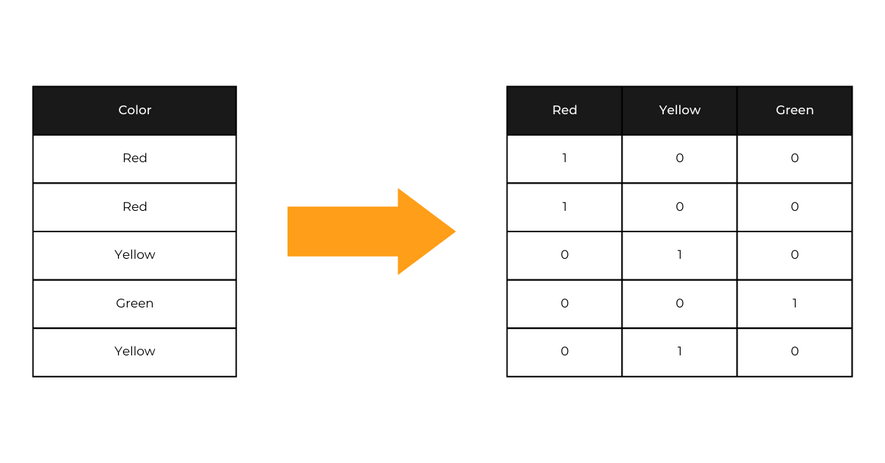

=> Dữ liệu chỉ còn 2 loại continuous và binary, chúng ta có thể sử dụng 2 mô hình GaussianNB và BernouliNB

- Ý tưởng: Xác định các feature nào là continuous, feature nào là binary và tính toán các xác xuất của feature với loại dữ liệu tương ứng (Giải thích ở file naive_bayes.ipynb)

In [8]:
class MixedNB():
    def __init__(self, gauss_index=None, bernouli_index=None):
        self.gauss_index = gauss_index # Index để tính xs của gauss
        self.bernouli_index = bernouli_index # Index để tính xs của bernouli


    def fit(self, X, Y): # Lưu trữ, tính toán những tham số cần thiết cho 2 mô hình gaussianNB và bernouliNB
        self.classes = np.unique(np.array(Y))
        self.n_features = X.shape[1]
        n_class = len(self.classes)
        self.class_priors = np.empty(shape=(n_class))

        self._calculate_stuffs(X, Y)

    def _calculate_stuffs(self, X, Y): # Tính toán means, vars, các P(i|c)  
        P_ic = []
        means = []
        vars_ = []

        for k, c in enumerate(self.classes): # Lặp qua tất cả các class
            Xc = X.iloc[np.where(Y == c)] # Lấy ra các X có cùng class
            temp = [] # Mảng lưu trữ các xs P(i|C) của class c
            temp_mean = [] # Mảng lưu trữ các mean của class c 
            temp_var = [] # Mảng lưu trữ các var của class c
            self.class_priors[k] = (len(Xc)) / (len(X)) # Tính toán xs prior của class c
            
            for i in range(X.shape[1]): # Lặp qua tất cả các feature của các record có cùng class c
                feat_probs_c = np.sum(Xc.iloc[:, i]) / len(Xc)

                temp.append(feat_probs_c)
                temp_mean.append(np.mean(Xc.iloc[:, i]))
                temp_var.append(np.var(Xc.iloc[:, i]))

            P_ic.append(temp)
            means.append(temp_mean)
            vars_.append(temp_var)

        # Lưu trữ các ma trận xs, means, vars của tất cả các class
        self.P_ic = np.array(P_ic)
        self.means = np.array(means)
        self.vars = np.array(vars_)


    def _pdf_binomial(self, x, feat_probs_class): # Hàm pdf của pp nhị thức
        return (feat_probs_class ** x) * ((1 - feat_probs_class) ** (1 - x))
    

    def _pdf_gauss(self, x, mean, variance): # Hàm pdf của pp gauss
        exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
        return (1 / np.sqrt(2 * np.pi * variance)) * exponent
    
    
    def _get_joint_probs(self, X): # Tính toán các xs posteriors

        class_probs = []
        for x in X:
            # print(x)
            posts = []

            for i in range(len(self.class_priors)):
                post = np.log(self.class_priors[i]) # Lấy ra xs priors ứng với class thứ i

                for j in range(X.shape[1]): # Xét theo index truyền vào để quyết định xem tính toán với pdf nào
        
                    if j in self.gauss_index:
                        post += np.log(self._pdf_gauss(x=x[j], mean=self.means[i,j], variance=self.vars[i, j]))
                    elif j in self.bernouli_index:
        
                        post += np.log(self._pdf_binomial(x=x[j], feat_probs_class=self.P_ic[i, j]))

                posts.append(post)
            class_probs.append(posts)

        return np.array(class_probs)
    
    
    def predict(self, X):
        probs = self._get_joint_probs(X)
        # print(probs)
        Y_preds = []
        for prob in probs: # Lặp qua tất cả các xs posteriors
            Y_preds.append(self.classes[np.argmax(prob)]) # Lấy index của xs max => Phân loại

        return np.array(Y_preds)



- Do bộ data có nhiều loại dữ liệu, cụ thể là feature từ (0-6) là liên tục, feature (7-n) là binary (Do đã áp dụng one hot encode) nên chúng ta có thể truyền dữ liệu index dưới dạng range

In [9]:
mixNB = MixedNB(continuous_idxs, binary_idxs)
mixNB.fit(X_train, Y_train["damage_grade"])


In [10]:
preds = mixNB.predict(X_test.to_numpy())
preds.shape

C:\Users\Admin\AppData\Local\Temp\ipykernel_1120\1289597055.py:69: RuntimeWarning: divide by zero encountered in log
  post += np.log(self._pdf_binomial(x=x[j], feat_probs_class=self.P_ic[i, j]))


(52121,)

- Do code chưa tối ưu về thuật toán nên thời gian chạy khá lâu (20 - 30s) nhưng độ chính xác cũng không quá kém với những mô hình NB khác 

In [11]:
print(metrics.classification_report(Y_test, preds, digits=4))

              precision    recall  f1-score   support

           0     0.4162    0.5765    0.4834      5056
           1     0.6527    0.4038    0.4989     29611
           2     0.4400    0.6755    0.5329     17454

    accuracy                         0.5116     52121
   macro avg     0.5030    0.5520    0.5051     52121
weighted avg     0.5585    0.5116    0.5088     52121



[[ 2915  1303   838]
 [ 3487 11958 14166]
 [  602  5061 11791]]


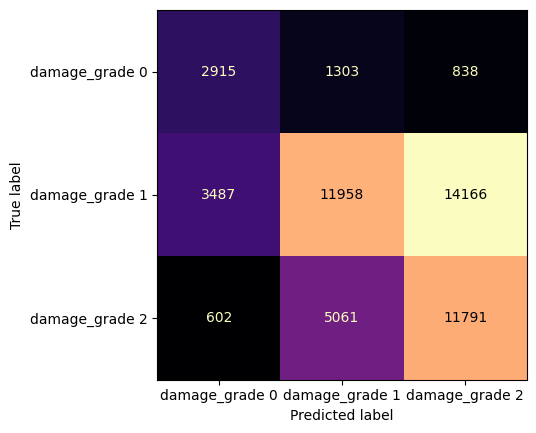

In [12]:
cm = metrics.confusion_matrix(Y_test, preds)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot(cmap="magma", colorbar=False)
print(cm)

---

## Dùng kết hợp 2 thư viện GaussianNB và BernoulliNB để tạo thành mô hình mới

In [13]:
class MixedNB2():
    def __init__(self, continuous_idx, binary_idx):
        self.continuous_idx = continuous_idx
        self.binary_idx = binary_idx

        self.gaussNB = GaussianNB()
        self.berNB = BernoulliNB()

    def fit(self, X, Y): # fit cả 2 model theo index truyền vào
        self.gaussNB.fit(X.iloc[:,self.continuous_idx], Y)
        self.berNB.fit(X.iloc[:, self.binary_idx], Y)

    def predict(self, X):
        y_pred = np.empty(X.shape[0])
        pred_probs_gauss = self.gaussNB.predict_joint_log_proba(X.iloc[:,self.continuous_idx]) # Lấy ra log(P(X|c)) ứng với mỗi xi trong X_test truyền vào (trong khoảng continuous_idx)
        pred_probs_bern = self.berNB.predict_joint_log_proba(X.iloc[:, self.binary_idx]) # Lấy ra log(P(X|c)) ứng với mỗi xi trong X_test truyền vào (trong khoảng binary_idx)
        log_posts = pred_probs_gauss + pred_probs_bern # Tính log(P(y|c)) 

        for i in range(len(log_posts)):
            y_pred[i] = np.argmax(log_posts[i])

        return np.array(y_pred, dtype=int)
        

In [14]:
start = dt.now()
mNB2 = MixedNB2(continuous_idxs, binary_idxs)
mNB2.fit(X_train, Y_train)
Y_preds = mNB2.predict(X_test)
running_secs = (dt.now() - start).microseconds

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
Y_preds

array([0, 1, 1, ..., 1, 0, 1])

In [16]:
print(f"time: {running_secs} microsecs")

time: 462142 microsecs


In [17]:
print(metrics.classification_report(Y_test, Y_preds, digits=4))

              precision    recall  f1-score   support

           0     0.4411    0.5277    0.4805      5056
           1     0.6185    0.7026    0.6579     29611
           2     0.5074    0.3615    0.4222     17454

    accuracy                         0.5714     52121
   macro avg     0.5223    0.5306    0.5202     52121
weighted avg     0.5641    0.5714    0.5617     52121



[[ 2668  2137   251]
 [ 2933 20805  5873]
 [  448 10697  6309]]


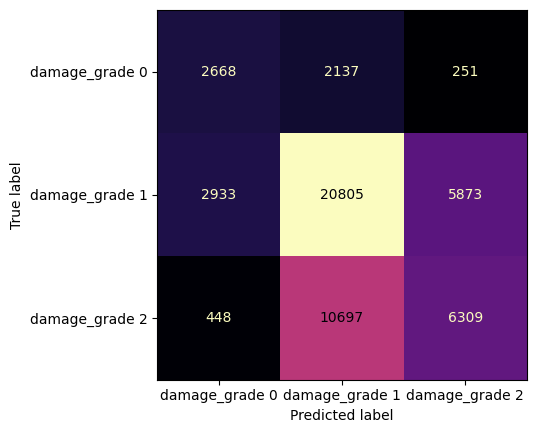

In [18]:
cm = metrics.confusion_matrix(Y_test, Y_preds)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot(cmap="magma", colorbar=False)
print(cm)

In [19]:
metrics.f1_score(Y_test, Y_preds, average="macro")

0.5201867133140704

---

## PCA 

- Scale

In [20]:
X0 = X_encoded.copy(deep=True)
scaler = StandardScaler()
scaled_X0 = scaler.fit_transform(X0)
# X0.iloc[:,continuous_idxs] = scaled_X0

In [21]:
pca = PCA(n_components=10)
pca_X0 = pca.fit_transform(X0)
pca_X0.shape

(260601, 10)

In [22]:
X0_train, X0_test, Y0_train, Y0_test = train_test_split(pca_X0, Y,test_size=0.2, random_state=192)

- Vì dữ liệu toàn liên tục nên sử dụng luôn GaussianNB

In [23]:
start = dt.now()
gauss = GaussianNB()
gauss.fit(X0_train, Y0_train)
Y0_preds = gauss.predict(X0_test)
running_secs = (dt.now() - start).microseconds


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
print(f"time: {running_secs} microsecs")

time: 92035 microsecs


In [25]:
print(metrics.classification_report(Y0_test, Y0_preds, digits=4))

              precision    recall  f1-score   support

           0     0.4358    0.3799    0.4060      5056
           1     0.6016    0.7767    0.6781     29611
           2     0.5088    0.2764    0.3582     17454

    accuracy                         0.5707     52121
   macro avg     0.5154    0.4777    0.4808     52121
weighted avg     0.5545    0.5707    0.5446     52121



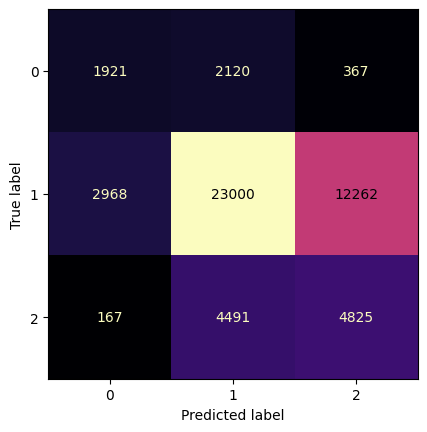

In [26]:
cm = metrics.confusion_matrix(Y0_preds, Y0_test)
metrics.ConfusionMatrixDisplay(cm).plot(cmap="magma", colorbar=False)

In [28]:
print(cm)

[[ 1921  2120   367]
 [ 2968 23000 12262]
 [  167  4491  4825]]


---

## So sánh

Ko PCA:
- accuracy: 0.5717
- F1: 0.5193
- Recall: 0.5302

PCA:
- accuracy: 0.5718
- F1: 0.4812
- Recall: 0.5464

- Độ chính xác không thay đổi nhiều: PCA không ảnh hưởng đáng kể đến độ chính xác của mô hình.
- F1 Score giảm: Sự giảm sút của F1 Score (từ 0.5193 xuống 0.4812) cho thấy sự giảm cân bằng giữa precision và recall, có nghĩa là mô hình trở nên kém hiệu quả hơn trong việc cân bằng giữa các trường hợp TP và số lượng các trường hợp được nhận diện.
- Recall tăng: Việc tăng recall (từ 0.5302 lên 0.5464) cho thấy mô hình trở nên tốt hơn trong việc phát hiện các trường hợp Positives.
